In [ ]:
import time

total = len(data_df)
mean = []
sd=[]

program_starts = time.time()
for idx in range(total):
    row = data_df.loc[idx]
    img_id, img_label = row['Image'], row['Label']
    img_fname = TRAIN_DIR + "/" + str(img_id) + ".png"
    img = Image.open(img_fname)
    imarr = np.array( img, dtype=np.float)
    mean.append(np.mean( imarr, axis=(0, 1)))
    sd.append(np.std( imarr, axis=(0, 1)))
    
print("Train set done within {} seconds".format((time.time() - program_starts)))
print("Number of train Images = ", len(mean))
print("[TrainSET] Mean = {}, STD= {}".format( np.mean(mean,  axis=0), np.std(sd,  axis=0) ))

test_df = pd.read_csv(TEST_CSV)
total = len(test_df)
for idx in range(total):
    row = test_df.loc[idx]
    img_id, img_label = row['Image'], row['Label']
    img_fname = TEST_DIR + "/" + str(img_id) + ".png"
    img = Image.open(img_fname)
    imarr = np.array( img, dtype=np.float)
    mean.append(np.mean( imarr, axis=(0, 1)))
    sd.append(np.std( imarr, axis=(0, 1)))
    
print("Total set done within {} seconds".format((time.time() - program_starts)))
print("Number of Total Images = ", len(mean))
print("[Total] Mean = {}, STD= {}".format( np.mean(mean,  axis=0), np.std(sd,  axis=0) ))


Train set done within 419.13140082359314 seconds
Number of train Images =  19236
[TrainSET] Mean = [20.21617694 13.52421909 13.8870552 ], STD= [13.8264304  12.89793999 16.00301366]
Total set done within 609.826495885849 seconds
Number of Total Images =  27479
[Total] Mean = [20.19658003 13.49394561 13.86706486], STD= [13.82191017 12.81857906 15.98359092]


# Human Protein Multi Label Image Classification - Transfer Learning & Regularization


How a CNN learns ([source](https://developer.nvidia.com/discover/convolutional-neural-network)):

![cnn-learning](https://developer.nvidia.com/sites/default/files/pictures/2018/convolutional_neural_network.png)

Layer visualization ([source](https://medium.com/analytics-vidhya/deep-learning-visualization-and-interpretation-of-neural-networks-2f3f82f501c5)):

![cnn-learning](https://miro.medium.com/max/1610/1*WysCJ6Ynecvviwctt6WDlQ.png)


Transfer learning ([source](https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/)):
![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)

This is a starter notebook for the competition [Zero to GANs - Human Protein Classification](https://www.kaggle.com/c/jovian-pytorch-z2g). It incorporates transfer learning, and other techniques from https://jovian.ml/aakashns/05b-cifar10-resnet

In [1]:
!nvidia-smi

Thu Jul  2 18:22:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preparing the Data

In [ ]:
!wget -i 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/21265/1267903/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1593723009&Signature=YPqI1hhCcDeJNb6aC9trkl54WjSYkifL5Ye%2BYyPzZhV6bEtbvdfqk%2BzvL30ma6AbWorKQN2PAfTsl%2B8PHQT2xkGIxKix42ikBdsIKxigemwyS6z%2BtC%2BeUN%2F7M%2Fk%2FzBkEVw1LsU2P8EWpOObVNMpXbW4epuI9v8AfCaVfQTrC3bHK6XC6cGizHvo10EzWD8e7YXE%2FwVJNLZfyLiPQW4nRaWdoUnrYWekL7SV9H%2F1T0KzREQyVoc%2Fd9RhjskTKDlBfO4fxHOi%2FrkhX3rY1eBOmNZ2YGaR9MjXxLWgey4mVu1jJrn2HYzxvqTk8rH35KNiqbzcz0q%2BZKjFslyNmaiVAwA%3D%3D&response-content-disposition=attachment%3B+filename%3Djovian-pytorch-z2g.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Human protein atlas/train/3069.png  
  inflating: Human protein atlas/train/30690.png  
  inflating: Human protein atlas/train/30691.png  
  inflating: Human protein atlas/train/30692.png  
  inflating: Human protein atlas/train/30693.png  
  inflating: Human protein atlas/train/30694.png  
  inflating: Human protein atlas/train/30696.png  
  inflating: Human protein atlas/train/30697.png  
  inflating: Human protein atlas/train/30698.png  
  inflating: Human protein atlas/train/30699.png  
  inflating: Human protein atlas/train/307.png  
  inflating: Human protein atlas/train/3070.png  
  inflating: Human protein atlas/train/30700.png  
  inflating: Human protein atlas/train/30701.png  
  inflating: Human protein atlas/train/30702.png  
  inflating: Human protein atlas/train/30704.png  
  inflating: Human protein atlas/train/30706.png  
  inflating: Human protein atlas/train/30707.png  
  inflating: Human protein atlas/tr

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
DATA_DIR = 'Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/test'                             

TRAIN_CSV = DATA_DIR + '/train.csv'                       
TEST_CSV = 'submission.csv' 

In [3]:
data_df = pd.read_csv(TRAIN_CSV)
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [4]:
print(data_df.shape[0], 'masks found')
print(data_df['Image'].value_counts().shape[0])
# just use green for now
data_df['green_path'] = data_df['Image'].map(lambda x: os.path.join(TRAIN_DIR, '{}.png'.format(x)))
data_df['target_list'] = data_df['Label'].map(lambda x: [int(a) for a in x.split(' ')])
data_df.head()

19236 masks found
19236


,Image,Label,green_path,target_list
0,19567,9,Human protein atlas/train/19567.png,[9]
1,29993,6 4,Human protein atlas/train/29993.png,"[6, 4]"
2,17186,1 4,Human protein atlas/train/17186.png,"[1, 4]"
3,29600,6 2,Human protein atlas/train/29600.png,"[6, 2]"
4,701,3 4,Human protein atlas/train/701.png,"[3, 4]"


9 count: 1278
6 count: 5711
4 count: 9066
1 count: 1752
2 count: 2542
3 count: 1977
7 count: 2629
0 count: 2088
8 count: 1037
5 count: 1109


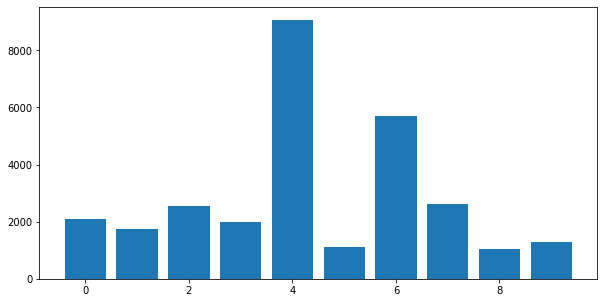

In [5]:
from itertools import chain
from collections import Counter
all_labels = list(chain.from_iterable(data_df['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
fig, ax1 = plt.subplots(1,1, figsize = (10, 5))
ax1.bar(n_keys, [c_val[k] for k in n_keys])
for k,v in c_val.items():
    print(k, 'count:', v)

In [6]:
# create a categorical vector
data_df['target_vec'] = data_df['target_list'].map(lambda ck: [i in ck for i in range(max_idx+1)])
data_df.sample(3)

,Image,Label,green_path,target_list,target_vec
9844,17113,6,Human protein atlas/train/17113.png,[6],"[False, False, False, False, False, False, Tru..."
4092,3861,4,Human protein atlas/train/3861.png,[4],"[False, False, False, False, True, False, Fals..."
3699,20464,0 5 4,Human protein atlas/train/20464.png,"[0, 5, 4]","[True, False, False, False, True, True, False,..."


In [7]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [8]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [9]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

### Data augmentations

In [10]:
imagenet_stats = ([20.19658003/255.0, 13.49394561/255.0, 13.86706486/255.0], [13.82191017/255.0, 12.81857906/255.0, 15.98359092/255.0])

train_tfms = T.Compose([
    # T.Resize(256), 
    T.RandomCrop(512, padding=8, padding_mode='reflect'),
#     T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation((-180,+180)),
    T.ToTensor(), 
    T.Normalize(*imagenet_stats,inplace=True), 
    #T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
    # T.Resize(256), 
    T.ToTensor(), 
    T.Normalize(*imagenet_stats)
])

In [11]:
np.random.seed(100)
msk = np.random.rand(len(data_df)) < 0.7

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

9 count: 889
6 count: 4004
4 count: 6351
1 count: 1259
3 count: 1384
0 count: 1482
2 count: 1785
7 count: 1817
8 count: 738
5 count: 785


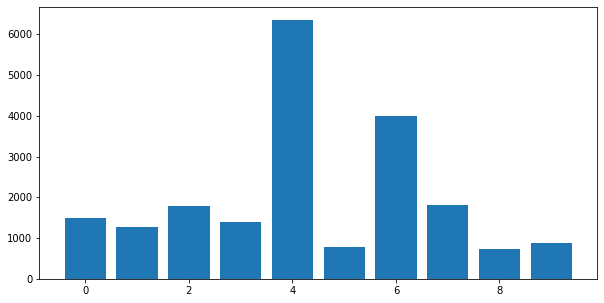

In [12]:
from itertools import chain
from collections import Counter
all_labels = list(chain.from_iterable(train_df['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
fig, ax1 = plt.subplots(1,1, figsize = (10, 5))
ax1.bar(n_keys, [c_val[k] for k in n_keys])
for k,v in c_val.items():
    print(k, 'count:', v)

In [13]:
train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_tfms)
len(train_ds), len(val_ds)

(13500, 5736)

In [14]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: Nucleoplasm(4) Cytosol(6)


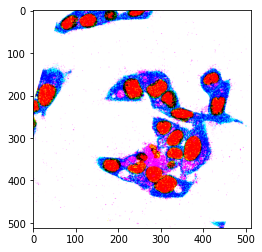

In [15]:
show_sample(*train_ds[1])

### DataLoaders

In [16]:
batch_size = 32

In [17]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, 
                    num_workers=4, pin_memory=True)
full_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=4, pin_memory=True)

In [18]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


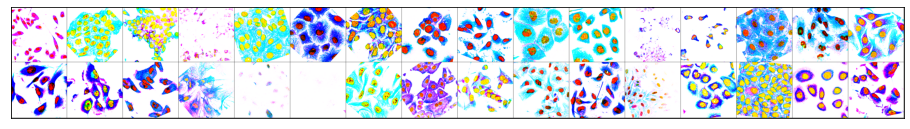

In [19]:
show_batch(train_dl, invert=True)

## Model - Transfer Learning

In [20]:
def F_score(output, label, threshold=0.38, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [22]:
criterion = FocalLoss()
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

[Learn about ResNets.](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)

Check out torchvision models: https://pytorch.org/docs/stable/torchvision/models.html

In [23]:
resnet18 = models.resnet50()
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
class ProteinResnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
device = get_default_device()
device

device(type='cuda')

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
full_dl = DeviceDataLoader(full_dl, device)

## Training

In [28]:

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay, momentum=0.9)
    # Set up one-cycle learning rate scheduler
    #sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, base_momentum = 0.8, steps_per_epoch=len(train_loader))
    #sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    #sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2 )
    sched = torch.optim.lr_scheduler.CyclicLR(optimizer, max_lr=max_lr, base_lr=0.00001, step_size_up=50, step_size_down=len(train_loader)*3)
    best_acc = 0.0
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            
            sched.step()
            
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        if best_acc < result['val_score'] :
            best_acc = result['val_score']
            torch.save(model.state_dict(), 'best-epoch22.pth')
        history.append(result)
    print(f'best accuracy = {best_acc}')
    return history
# model.load_state_dict(torch.load('best-epoch.pth'))0.8084920644760132 0.8115624189376831 0.8118786811828613

In [29]:
model = to_device(ProteinResnet(), device)
model.load_state_dict(torch.load('best-epoch21.pth'))

<All keys matched successfully>

In [30]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.17119300365447998, 'val_score': 0.7958724498748779}]

First, freeze the ResNet layers and train some epochs. This only trains the final layer to start classifying the images.

In [62]:
model.freeze()

In [31]:
epochs = 10
max_lr = 0.005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

In [67]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0014, train_loss: 0.3748, val_loss: 0.3349, val_score: 0.4289



Epoch [1], last_lr: 0.0038, train_loss: 0.3177, val_loss: 0.2930, val_score: 0.5020



Epoch [2], last_lr: 0.0050, train_loss: 0.2757, val_loss: 0.2498, val_score: 0.6296



Epoch [3], last_lr: 0.0048, train_loss: 0.2409, val_loss: 0.2231, val_score: 0.7042



Epoch [4], last_lr: 0.0041, train_loss: 0.2211, val_loss: 0.2066, val_score: 0.7311



Epoch [5], last_lr: 0.0031, train_loss: 0.2087, val_loss: 0.1941, val_score: 0.7501



Epoch [6], last_lr: 0.0019, train_loss: 0.2017, val_loss: 0.1885, val_score: 0.7647



Epoch [7], last_lr: 0.0009, train_loss: 0.1950, val_loss: 0.1844, val_score: 0.7749



Epoch [8], last_lr: 0.0002, train_loss: 0.1901, val_loss: 0.1825, val_score: 0.7825



Epoch [9], last_lr: 0.0000, train_loss: 0.1872, val_loss: 0.1810, val_score: 0.7793
best accuracy = 0.7824707627296448
CPU times: user 41min 8s, sys: 31min 34s, total: 1h 12min 42s
Wall time: 1h 16min 9s


Now, unfreeze and train some more.

In [32]:
model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(7, 0.003, model, train_dl, val_dl, 
                         grad_clip=grad_clip,
                         opt_func=torch.optim.SGD)

In [ ]:
%%time
history += fit_one_cycle(8, 0.002, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0020, train_loss: 0.1697, val_loss: 0.1678, val_score: 0.8022



Epoch [1], last_lr: 0.0013, train_loss: 0.1694, val_loss: 0.1678, val_score: 0.8058



Epoch [2], last_lr: 0.0007, train_loss: 0.1674, val_loss: 0.1670, val_score: 0.8076



Epoch [3], last_lr: 0.0000, train_loss: 0.1660, val_loss: 0.1656, val_score: 0.8077



Epoch [4], last_lr: 0.0020, train_loss: 0.1658, val_loss: 0.1679, val_score: 0.8003



Epoch [5], last_lr: 0.0013, train_loss: 0.1658, val_loss: 0.1665, val_score: 0.8062



Epoch [6], last_lr: 0.0007, train_loss: 0.1645, val_loss: 0.1655, val_score: 0.8085



Epoch [7], last_lr: 0.0000, train_loss: 0.1619, val_loss: 0.1650, val_score: 0.8068
best accuracy = 0.8084920644760132
CPU times: user 33min 9s, sys: 24min 49s, total: 57min 58s
Wall time: 1h 48s


In [ ]:
%%time
history += fit_one_cycle(4, 0.004, model, full_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0030, train_loss: 0.1670, val_loss: 0.1658, val_score: 0.8041



Epoch [1], last_lr: 0.0020, train_loss: 0.1635, val_loss: 0.1663, val_score: 0.8037



Epoch [2], last_lr: 0.0010, train_loss: 0.1606, val_loss: 0.1627, val_score: 0.8119



Epoch [3], last_lr: 0.0000, train_loss: 0.1572, val_loss: 0.1632, val_score: 0.8081
best accuracy = 0.8118786811828613
CPU times: user 16min 36s, sys: 12min 27s, total: 29min 3s
Wall time: 30min 24s


In [ ]:
%%time
history += fit_one_cycle(4, 0.001, model, full_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0008, train_loss: 0.1570, val_loss: 0.1633, val_score: 0.8128



Epoch [1], last_lr: 0.0005, train_loss: 0.1562, val_loss: 0.1627, val_score: 0.8092



Epoch [2], last_lr: 0.0003, train_loss: 0.1545, val_loss: 0.1628, val_score: 0.8078



Epoch [3], last_lr: 0.0000, train_loss: 0.1537, val_loss: 0.1623, val_score: 0.8088
best accuracy = 0.8128435611724854
CPU times: user 16min 34s, sys: 12min 25s, total: 28min 59s
Wall time: 30min 22s


In [ ]:
train_time='22:00'

In [ ]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

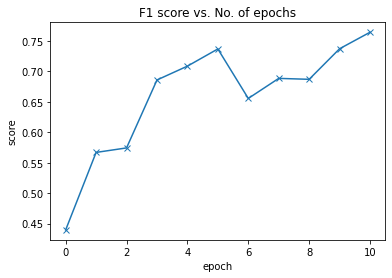

In [ ]:
plot_scores(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

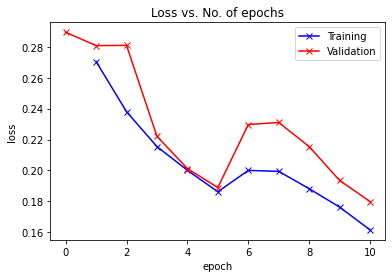

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

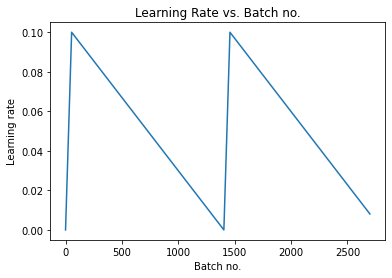

In [ ]:
plot_lrs(history)

## Making predictions and submission

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [ ]:
test_df = pd.read_csv(TEST_CSV)
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=valid_tfms)

In [ ]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Prediction:  tensor([1.0265e-04, 2.0268e-02, 1.5101e-02, 5.0133e-04, 9.8046e-01, 3.6153e-03,
        9.7783e-01, 2.4578e-03, 9.6238e-04, 1.6299e-04], device='cuda:0',
       grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: Nucleoplasm(4) Cytosol(6)


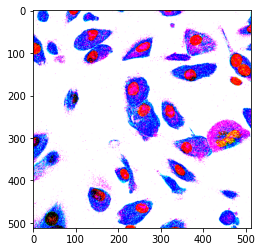

In [ ]:
predict_single(test_dataset[100][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:  tensor([0.6597, 0.0073, 0.0158, 0.4158, 0.0691, 0.0048, 0.0199, 0.0084, 0.0111,
        0.0113], device='cuda:0', grad_fn=<SelectBackward>)
Labels: Mitochondria(0)


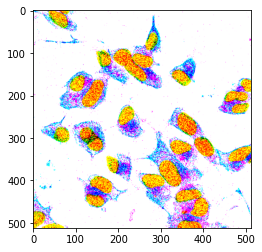

In [ ]:
predict_single(test_dataset[74][0])

In [ ]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True), device)

In [ ]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [ ]:
test_preds = predict_dl(test_dl, model)

In [ ]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.sample(20)

,Image,Label
3411,13165,2
5144,18847,9
5639,14811,4
2987,17257,1
8011,25572,2
7532,1804,9
420,23885,7
7630,3799,7
1694,29464,7
1717,5540,6


In [ ]:
sub_fname = 'submission13.csv'

In [ ]:
submission_df.to_csv(sub_fname, index=False)

## Save and Commit

In [ ]:
weights_fname = 'protein-resnet.pth'
torch.save(model.state_dict(), weights_fname)

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet34', 
                       epochs=2*epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_score=history[-1]['val_score'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

In [ ]:
project_name='protein-advanced'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])